# Import Data

In [1]:
import pandas as pd
from collections import Counter
import spacy
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:/Users/Alvis Cheung/Desktop/Bayes/Term 3/Applied Research Project/Data Ready/pushshift_abarth_20230509.csv")
df = df.drop(columns=['Unnamed: 0','cm'])
df

,title,author,text,numcm,score,up_ratio,link,time,id
0,Brakes suggestions please?,LW1204,"Hello everyone, I own a 2016 Abarth 595 which ...",9,4,1.00,https://www.reddit.com/r/abarth/comments/u7iaz...,1650410093,u7iazu
1,Public Abarth Announcement (PAA) - Don’t take ...,MarcosaurusRex,NaN,12,15,0.89,https://www.reddit.com/r/abarth/comments/u7fzx...,1650403676,u7fzxx
2,Post TD04L install Video! (No tune yet),[deleted],[deleted],17,28,0.95,https://www.reddit.com/r/abarth/comments/u6u1b...,1650334394,u6u1bf
3,Oops. Deleted my render. Hope you like it.,HippySol,NaN,5,36,0.98,https://www.reddit.com/r/abarth/comments/u6tkc...,1650332971,u6tkch
4,For sale!,CatchPotential,NaN,3,3,0.81,https://www.reddit.com/r/abarth/comments/u6nsn...,1650316617,u6nsn4
...,...,...,...,...,...,...,...,...,...
4751,My favorite picture I've seen of a 500 Abarth,[deleted],NaN,0,2,NaN,https://www.reddit.com/r/abarth/comments/110qv...,1349482841,110qvl
4752,La Abarth 695 Edizione Maserati debutta alla M...,Fiatgroup,NaN,0,1,NaN,https://www.reddit.com/r/abarth/comments/trgg4...,1337250227,trgg4
4753,Top Gear - Jeremy Clarkson drives the Fiat 500...,[deleted],NaN,0,1,NaN,https://www.reddit.com/r/abarth/comments/mks3j...,1321919928,mks3j
4754,Carlo Abarth Biography,[deleted],NaN,0,1,NaN,https://www.reddit.com/r/abarth/comments/mkroz...,1321919332,mkroz


In [3]:
dfCM = pd.read_csv("C:/Users/Alvis Cheung/Desktop/Bayes/Term 3/Applied Research Project/Data Ready/pushshift_abarth_cm_20230509.csv")
dfCM = dfCM.drop(columns=['Unnamed: 0'])
dfCM

,author,id,parent id,post id,text,time,score
0,Kronic_Repulse1,i5etc9q,t3_u7iazu,u7iazu,I bought centric brake pads and rotors oem plu...,1.650411e+09,3
1,Kronic_Repulse1,i5etb57,t3_u7iazu,u7iazu,I bought centric brake pads and rotors oem plu...,1.650411e+09,2
2,Milnoc,i5gzl9m,t3_u7iazu,u7iazu,"I'm in North America, so different Abarth mech...",1.650457e+09,2
3,mcmercf1,i5nghnj,t3_u7iazu,u7iazu,"Since you're in the UK, look at EBC's redstuff...",1.650567e+09,2
4,LW1204,i5ihzkm,t1_i5gzl9m,u7iazu,Thank I shall have a look,1.650479e+09,1
...,...,...,...,...,...,...,...
30257,maybeathrowaway88,crmicgx,t3_2sj8oi,2sj8oi,"I had the same MA engine in a gulietta 170, ho...",1.432737e+09,1
30258,chupacabraiii,cs0gg02,t3_2sj8oi,2sj8oi,Damn for some reason I thought there'd be more...,1.433848e+09,1
30259,FETT7022,cs4q4bw,t3_2sj8oi,2sj8oi,Wife and I just got a 13 abarth I'm in and I'l...,1.434148e+09,1
30260,rek,co5q6uw,t1_co5her1,2sj8oi,"Awesome, congrats! I just got mine very recent...",1.422629e+09,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     4756 non-null   object 
 1   author    4756 non-null   object 
 2   text      2373 non-null   object 
 3   numcm     4756 non-null   int64  
 4   score     4756 non-null   int64  
 5   up_ratio  2862 non-null   float64
 6   link      4756 non-null   object 
 7   time      4756 non-null   int64  
 8   id        4756 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 334.5+ KB


In [5]:
df.author.value_counts()

author
[deleted]               652
BIACKWOLF99258          175
Competitive_Yard_647     78
Manoww1995               55
MetalMattyPA             42
                       ... 
LorenLopez54              1
DexterDennis6544          1
EdGuerrero4757            1
Randolph451               1
Fiatgroup                 1
Name: count, Length: 1511, dtype: int64

In [6]:
df.text.value_counts()

text
[deleted]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          532
[removed]                   

# Cleaning

## Remove empty inputs

In [7]:
dfCMClean = dfCM[(dfCM.text!="[deleted]") &
             (dfCM.text!="[removed]") &
             (dfCM.text.notna())]
dfCMClean.text.value_counts()

text
Thanks!                                                                                                                                                                                                                                                                                       61
Thank you!                                                                                                                                                                                                                                                                                    41
Thanks                                                                                                                                                                                                                                                                                        31
Nice!                                                                                                                           

In [8]:
dfClean = df[(df.text!="[deleted]") &
             (df.text!="[removed]") &
             (df.text.notna())]
dfClean.text.value_counts()

text
I have recently taken primary control of my father's 2013 Fiat 500 Abarth and am looking to do some serious upgrades on it. I'm wondering if the community has any good recommendations for the best performance upgrades for the vehicle. I'm looking to do a lot bit-by-bit (seeing as I'm 19 and don't have much money.) Some things I can most likely do on my own, but I'm predicting a lot of it will need to be done by a shop.\n\n&amp;#x200B;\n\nWhat can I do to make this car faster, handle better, and still be road legal/pass emissions testing?\n\nAny recommendations are welcome! I'm hoping to start off with some cheap projects I can do at home before I start taking it in for bigger installs. Suggestions for both are encouraged.\n\n&amp;#x200B;\n\nThanks, everyone!                                                                                                                                                                                                   2
Hello everyone, I own a 2016 A

In [9]:
dfCleanText1 = dfClean.loc[dfClean.text.notnull()].reset_index(drop=True)
dfCleanText1

,title,author,text,numcm,score,up_ratio,link,time,id
0,Brakes suggestions please?,LW1204,"Hello everyone, I own a 2016 Abarth 595 which ...",9,4,1.0,https://www.reddit.com/r/abarth/comments/u7iaz...,1650410093,u7iazu
1,Exporting to U.S,romanian_billionaire,"Hello fellas,\n\nI got a ‘19 Competizione Seri...",6,6,1.0,https://www.reddit.com/r/abarth/comments/u6928...,1650274226,u69286
2,Dryflow air filters for 500Abarth?,mastercarD1,I wasn’t able to find dryflow air filters for ...,2,1,1.0,https://www.reddit.com/r/abarth/comments/u56x3...,1650142284,u56x3q
3,"Before I end up ordering one online, does anyo...",MetalMattyPA,I'll buy from EC if need be but if I can save ...,2,2,1.0,https://www.reddit.com/r/abarth/comments/u4cxj...,1650043031,u4cxjl
4,ESC light sensor issue.,No_Acanthisitta1102,Any one know what could be going on? My ESC li...,5,2,1.0,https://www.reddit.com/r/abarth/comments/u3x87...,1649987874,u3x87r
...,...,...,...,...,...,...,...,...,...
1372,Anyone ever shot flames?,aaronm109246,My friend said I shot a solid 2 foot flame out...,5,4,NaN,https://www.reddit.com/r/abarth/comments/353b6...,1430940187,353b69
1373,What's holding up the next gen Fiat 500?,borderwave2,"The current ""new Fiat 500"" has been in product...",3,4,NaN,https://www.reddit.com/r/abarth/comments/32xnf...,1429285829,32xnft
1374,What did I do.,ChYetter,So yesterday I traded in my BMW 328xi for a 20...,3,9,NaN,https://www.reddit.com/r/abarth/comments/2xepz...,1425080220,2xepzg
1375,Playing with Plastidip - Which one looks best ...,[deleted],"I can't decide. I like the red, but it might b...",4,7,NaN,https://www.reddit.com/r/abarth/comments/2ula5...,1422930234,2ula5g


In [10]:
dfCMCleanText1 = dfCMClean.loc[dfCMClean.text.notnull()].reset_index(drop=True)
dfCMCleanText1

,author,id,parent id,post id,text,time,score
0,Kronic_Repulse1,i5etc9q,t3_u7iazu,u7iazu,I bought centric brake pads and rotors oem plu...,1.650411e+09,3
1,Kronic_Repulse1,i5etb57,t3_u7iazu,u7iazu,I bought centric brake pads and rotors oem plu...,1.650411e+09,2
2,Milnoc,i5gzl9m,t3_u7iazu,u7iazu,"I'm in North America, so different Abarth mech...",1.650457e+09,2
3,mcmercf1,i5nghnj,t3_u7iazu,u7iazu,"Since you're in the UK, look at EBC's redstuff...",1.650567e+09,2
4,LW1204,i5ihzkm,t1_i5gzl9m,u7iazu,Thank I shall have a look,1.650479e+09,1
...,...,...,...,...,...,...,...
29605,maybeathrowaway88,crmicgx,t3_2sj8oi,2sj8oi,"I had the same MA engine in a gulietta 170, ho...",1.432737e+09,1
29606,chupacabraiii,cs0gg02,t3_2sj8oi,2sj8oi,Damn for some reason I thought there'd be more...,1.433848e+09,1
29607,FETT7022,cs4q4bw,t3_2sj8oi,2sj8oi,Wife and I just got a 13 abarth I'm in and I'l...,1.434148e+09,1
29608,rek,co5q6uw,t1_co5her1,2sj8oi,"Awesome, congrats! I just got mine very recent...",1.422629e+09,4


In [11]:
data = pd.concat([dfCleanText1.text, dfCMCleanText1.text], ignore_index=True)
data

0        Hello everyone, I own a 2016 Abarth 595 which ...
1        Hello fellas,\n\nI got a ‘19 Competizione Seri...
2        I wasn’t able to find dryflow air filters for ...
3        I'll buy from EC if need be but if I can save ...
4        Any one know what could be going on? My ESC li...
                               ...                        
30982    I had the same MA engine in a gulietta 170, ho...
30983    Damn for some reason I thought there'd be more...
30984    Wife and I just got a 13 abarth I'm in and I'l...
30985    Awesome, congrats! I just got mine very recent...
30986    Yea, I was surprised it was completely dead be...
Name: text, Length: 30987, dtype: object

## cleaning & tokenization

In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
nlp(data[0]).lang_

'en'

In [15]:
# filter for english comments
# remove stop-words, punctuations, non-English alphabets
def preprocess(text):
    doc = nlp(text)
    isEng = doc.lang_=='en'
    return [token.lemma_.lower() for token in doc
            if not token.is_stop and not token.is_punct and token.is_alpha]*isEng + []*(not isEng)

In [16]:
# basic cleaning and tokenisation
tkn_docs = [preprocess(text) for text in tqdm(data)]
tkn_docs = [t for t in tkn_docs if t != []]
tkn_docs

100%|██████████| 30987/30987 [05:22<00:00, 96.07it/s] 


[['hello',
  'abarth',
  'develop',
  'squealing',
  'noise',
  'think',
  'brake',
  'need',
  'replacement',
  'look',
  'upgrade',
  'stock',
  'brake',
  'get',
  'suggestion',
  'upgrade',
  'cost',
  'help',
  'appreciate'],
 ['hello',
  'fellas',
  'get',
  'competizione',
  'series',
  'eu',
  'configuration',
  'want',
  'export',
  'florida',
  'know',
  'possible',
  'register',
  'car',
  'order',
  'advice',
  'welcome',
  'great',
  'day'],
 ['able',
  'find',
  'dryflow',
  'air',
  'filter',
  'want',
  'deal',
  'oil',
  'base',
  'air',
  'filter',
  'like',
  'look',
  'well',
  'airflow',
  'ease',
  'maintenance',
  'expect',
  'power',
  'gain',
  'aem',
  'dryflow',
  'mile',
  'great',
  'recommendation',
  'great'],
 ['buy', 'ec', 'need', 'save', 'go', 'to', 'lol'],
 ['know',
  'go',
  'esc',
  'light',
  'come',
  'highway',
  'car',
  'drive',
  'fine',
  'normal',
  'cause',
  'check',
  'engine',
  'light',
  'come'],
 ['difference',
  'bhp',
  'autotrader'

In [119]:
# filter for long comments (at least 10 tokens)
tkn_long = [t for t in tkn_docs if len(t)>=10]
len(tkn_long)

13647

# gensim Topic Modelling

In [261]:
# load library
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel

import gensim
import pyLDAvis

In [120]:
# convert the data into gensim lda model required format
bigram = Phrases(tkn_long)
bigram_tkns = [bigram[line] for line in tkn_long]
bigram_tkns = [bigram[line] for line in tkn_long]

dictionary = Dictionary(bigram_tkns)
corpus = [dictionary.doc2bow(text) for text in bigram_tkns]

In [122]:
# check most frequent words
dictionary.most_common(100)

[('car', 7115),
 ('abarth', 4682),
 ('like', 2854),
 ('look', 2741),
 ('get', 2491),
 ('drive', 2289),
 ('go', 2004),
 ('think', 1995),
 ('good', 1982),
 ('buy', 1792),
 ('time', 1682),
 ('want', 1677),
 ('know', 1627),
 ('need', 1398),
 ('mile', 1383),
 ('find', 1375),
 ('new', 1360),
 ('thing', 1360),
 ('issue', 1349),
 ('work', 1332),
 ('engine', 1212),
 ('stock', 1204),
 ('come', 1198),
 ('way', 1087),
 ('sure', 1081),
 ('fiat', 1040),
 ('run', 1021),
 ('turbo', 1019),
 ('year', 1016),
 ('well', 985),
 ('lot', 978),
 ('love', 971),
 ('try', 967),
 ('replace', 966),
 ('little', 924),
 ('check', 898),
 ('say', 891),
 ('change', 879),
 ('wheel', 846),
 ('oil', 845),
 ('use', 842),
 ('great', 839),
 ('start', 837),
 ('problem', 816),
 ('sound', 814),
 ('right', 812),
 ('tune', 808),
 ('bad', 807),
 ('people', 793),
 ('bit', 779),
 ('thank', 776),
 ('pretty', 761),
 ('fun', 755),
 ('probably', 749),
 ('exhaust', 725),
 ('see', 696),
 ('intake', 676),
 ('tire', 673),
 ('day', 664),
 ('he

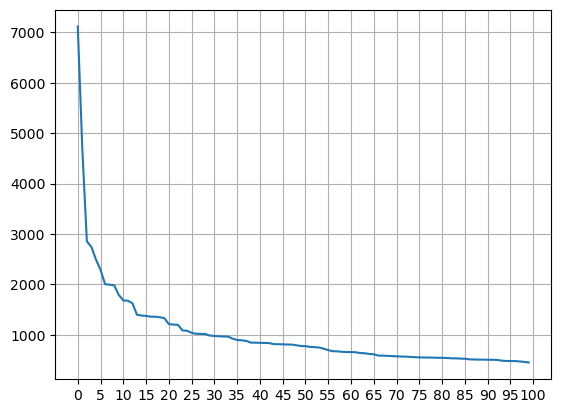

In [123]:
# frequency plot
plt.plot(np.arange(0,100), [v for k,v in dictionary.most_common(100)])
plt.xticks(np.arange(0,105,5))
plt.grid(True)

In [135]:
# put all to-be-removed words in a list (top 10 most frequent words + several other)
# remove those words from the token list
# convert the data into gensim lda model required format 
most_frequent_words = [x[0] for x in dictionary.most_common(10)] + ['new','want','fiat']
tkns_remove_top = [[tkn for tkn in texts if tkn not in most_frequent_words] for texts in bigram_tkns]
dictionary1 = Dictionary(tkns_remove_top)
corpus1 = [dictionary1.doc2bow(text) for text in tkns_remove_top]

# calculate the cohenrence scores for models of diff number of topics
coh_scores = []
for num_topics in tqdm(np.arange(5,21)):
    # lda topic modelling
    lda_model = LdaModel(
        corpus=corpus1, num_topics=num_topics, id2word=dictionary1, random_state=123)
    # model to get the coherence score
    coherence_model_lda = CoherenceModel(
        model=lda_model, texts=tkns_remove_top, dictionary=dictionary1, coherence='c_v')
    coh_scores.append(coherence_model_lda.get_coherence())
    
coh_scores

100%|██████████| 16/16 [04:02<00:00, 15.15s/it]


[0.5514052148171419,
 0.557839100186349,
 0.5309866020838526,
 0.542240946345685,
 0.5432571534069234,
 0.5004242259928083,
 0.5051892519777098,
 0.4977319311680031,
 0.49556372707657326,
 0.49137423320008755,
 0.4842665885088353,
 0.47466306919383383,
 0.4459983892338939,
 0.4437269948753158,
 0.4686786020021997,
 0.4514993723909372]

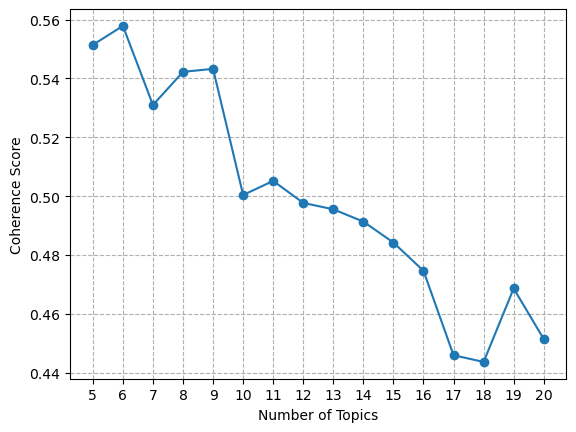

In [136]:
# plot coherence score VS number of topics
plt.plot(np.arange(5,21), coh_scores, marker="o")
plt.ylabel("Coherence Score")
plt.xlabel("Number of Topics")
plt.xticks(np.arange(5,21))
plt.grid(True, ls="--")

In [137]:
# define the optimal number of topics (highest coherence score, less topics)
bestNum = 6
lda_model = LdaModel(
    corpus=corpus1, num_topics=bestNum, id2word=dictionary1, random_state=123)

In [267]:
#lda_model.save("LDAmodel")

In [ ]:
lda_model = LdaModel.load("LDAmodel")

In [138]:
# show the topics' words
lda_model.show_topics(num_words = 8)

[(0,
  '0.012*"time" + 0.008*"issue" + 0.008*"mile" + 0.007*"thing" + 0.006*"work" + 0.006*"love" + 0.006*"start" + 0.006*"know"'),
 (1,
  '0.014*"wheel" + 0.009*"tire" + 0.008*"work" + 0.007*"black" + 0.005*"brake" + 0.005*"need" + 0.005*"red" + 0.005*"well"'),
 (2,
  '0.012*"stock" + 0.010*"exhaust" + 0.010*"intake" + 0.007*"turbo" + 0.007*"sound" + 0.007*"engine" + 0.007*"tune" + 0.006*"loud"'),
 (3,
  '0.008*"know" + 0.008*"lot" + 0.008*"nice" + 0.006*"people" + 0.006*"love" + 0.005*"well" + 0.004*"come" + 0.004*"great"'),
 (4,
  '0.011*"oil" + 0.008*"replace" + 0.007*"check" + 0.007*"issue" + 0.007*"engine" + 0.006*"need" + 0.006*"know" + 0.005*"change"'),
 (5,
  '0.009*"mile" + 0.008*"find" + 0.008*"price" + 0.008*"tune" + 0.007*"need" + 0.006*"sell" + 0.006*"year" + 0.005*"well"')]

## check example comments for each topic

In [195]:
# max probability of a document to topic
maxp = {t: 0 for t in np.arange(0,bestNum)}

for i, doc in enumerate(doc2topic):
    for t,p in doc:
        maxp[t] = max(maxp[t], p)

maxp

{0: 0.9904431,
 1: 0.9804351,
 2: 0.978199,
 3: 0.98283076,
 4: 0.991315,
 5: 0.9772095}

In [141]:
# 2nd max probability of a document to topic
max2p = {t: 0 for t in np.arange(0,bestNum)}

for i, doc in enumerate(doc2topic):
    for t,p in doc:
        isMax = p==maxp[t]
        max2p[t] = max(max2p[t], p)*(not isMax) + max2p[t]*(isMax)

max2p

{0: 0.9874517321586609,
 1: 0.9774466156959534,
 2: 0.9773119688034058,
 3: 0.9824279546737671,
 4: 0.9875999093055725,
 5: 0.9765920042991638}

In [142]:
# get the corresponding comments
maxi = {t: [] for t in np.arange(0,bestNum)}

for i, doc in enumerate(doc2topic):
    for t,p in doc:
        if p == maxp[t]:
            maxi[t].append(i)
        if p == max2p[t]:
            maxi[t].append(i)

myKeys = list(maxi.keys())
myKeys.sort()
maxi = {i: [data[ii] for ii in maxi[i]] for i in myKeys}
 
maxi

{0: ["Hey all, just got word from the dealer that they have built a new engine from parts for my 2013 500 Abarth as FCA North America apparently doesn't have full blocks, long blocks or short blocks in stock anymore. And, importantly, that all of this work is done under warranty (Hurray! Only took 4 months).\n\nThe only thing that this has me worried about is that, unlike crate engines (that are tested on an engine dyno before leaving the factory), they have no way of testing the engine before putting it into the car.\n\nAside the obvious (gasket leaks, coolant consumption, oil consumption) anything else I should keep an eye out for to verify my newly built engine is healthy when I get it back?",
  'Yes I’m running 93 now, I’ll start by chasing boost leaks from the turbo smart parts with the forge units, I am hoping I get more pep there, the multi air springs also make sense in function to me after doing some research so I am looking forward to getting those on.\n\nIt’s also possible w

In [145]:
for i, topic in enumerate(lda_model.show_topics(num_words = 8)):
    print("Topic", topic[0])
    print(topic[1])
    print("Max prob:", maxp[i], max2p[i])
    print("------------------------------------------------------")
    print("Examples:")
    print("1)", maxi[i][0])
    print()
    print("2):", maxi[i][1])
    print("===================================================================")

Topic 0
0.012*"time" + 0.008*"issue" + 0.008*"mile" + 0.007*"thing" + 0.006*"work" + 0.006*"love" + 0.006*"start" + 0.006*"know"
Max prob: 0.9904434 0.9874517321586609
------------------------------------------------------
Examples:
1) Hey all, just got word from the dealer that they have built a new engine from parts for my 2013 500 Abarth as FCA North America apparently doesn't have full blocks, long blocks or short blocks in stock anymore. And, importantly, that all of this work is done under warranty (Hurray! Only took 4 months).

The only thing that this has me worried about is that, unlike crate engines (that are tested on an engine dyno before leaving the factory), they have no way of testing the engine before putting it into the car.

Aside the obvious (gasket leaks, coolant consumption, oil consumption) anything else I should keep an eye out for to verify my newly built engine is healthy when I get it back?

2): Yes I’m running 93 now, I’ll start by chasing boost leaks from th

## pyLDAvis

In [230]:
print("Num docs:",len(tkn_long))
print("Num Vocabs:",len(dictionary1))
print("Num topics:", bestNum)

Num docs: 13647
Num Vocabs: 15493
Num topics: 6


In [231]:
# topic-to-word probability
topic2word = lda_model.state.get_lambda()
topic2word.shape, topic2word

((6, 15493),
 array([[3.8257450e+01, 1.0913952e+02, 2.8022787e+01, ..., 1.6673353e-01,
         1.6673353e-01, 1.6738775e-01],
        [1.6810320e+02, 4.6503056e+01, 4.0269428e-01, ..., 4.8603797e-01,
         4.8603797e-01, 1.6686146e-01],
        [4.9340984e+01, 2.5917852e+01, 1.3804189e+00, ..., 1.6680443e-01,
         1.6680443e-01, 1.6684523e-01],
        [1.2654246e+01, 6.5108452e+01, 9.1061121e-01, ..., 1.6681045e-01,
         1.6681045e-01, 1.6685505e-01],
        [3.6172787e+01, 5.6275478e+01, 2.9959488e+00, ..., 6.1135978e-01,
         6.1135978e-01, 4.2856491e-01],
        [1.6813307e+01, 6.0758930e+01, 7.4090356e-01, ..., 1.6677733e-01,
         1.6677733e-01, 5.8692348e-01]], dtype=float32))

In [223]:
# doc-to-topic probability
doc2topic = [lda_model.get_document_topics(corp, minimum_probability=0) for corp in corpus1] #list of lists of tuples

doc2top = [{t:p for t,p in LL} for LL in doc2topic]
doc2top = pd.DataFrame(doc2top).values.tolist()
doc2top = np.array(doc2top)

doc2top /= doc2top.sum(axis=1, keepdims=True)

doc2top.shape, doc2top

((13647, 6),
 array([[0.01134036, 0.15828614, 0.01141087, 0.01121358, 0.79650171,
         0.01124733],
        [0.01014072, 0.01011905, 0.01018213, 0.83828757, 0.01012315,
         0.12114737],
        [0.00809587, 0.00807538, 0.00807804, 0.0080883 , 0.11321608,
         0.85444633],
        ...,
        [0.01412625, 0.01411817, 0.01404328, 0.01406333, 0.24004672,
         0.70360224],
        [0.008003  , 0.00800925, 0.18009167, 0.00802704, 0.1468177 ,
         0.64905133],
        [0.45305044, 0.01203428, 0.11324772, 0.01209224, 0.39752683,
         0.01204848]]))

In [249]:
# dictionary
vocab = [v for k,v in dictionary1.items()]

In [242]:
# length of each document
doc_lengths = [len(doc) for doc in tkns_remove_top]

In [260]:
# frequency of each word in the whole dataset
term_frequency = dictionary1.cfs
myKeys = list(term_frequency.keys())
myKeys.sort()
term_frequency = {i: term_frequency[i] for i in myKeys}

In [262]:
prepared_data = pyLDAvis.prepare(
    topic2word, 
    doc2top, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, 
    sort_topics=False 
)

In [263]:
pyLDAvis.display(prepared_data)

# old ver Cleaning (don't run)

In [15]:
#pip install langdetect

  Using cached langdetect-1.0.9-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [11]:
from langdetect import detect
import re # remove url
import string # remove punctuation

In [12]:
# remove url's
def remove_url(text):
     return re.sub(r"https?:\S*", "", text)

In [19]:
# remove punctuations
def remove_punc(text):
    return text.translate(str.maketrans('', '', '!"#$%&()*+-/:;<=>@[\]^_`{|}~£'))

In [19]:
print(string.punctuation)
print('!"#$%&()*+-/:;<=>@[\]^_`{|}~£')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+-/:;<=>@[\]^_`{|}~£


In [13]:
# standardize "'"
def replace_specialPunc(text):
    return text.replace('’',"'").replace('‘',"'")

In [21]:
# remove '[removed]'
# standardize "'"
# remove url
# remove punctuations
# trim spaces
dfCleanCleanText1 = [remove_punc(remove_url(replace_specialPunc(t.replace("[removed]","")))).strip() for t in data]



In [22]:
# check for language of the texts
langList = [detect(t) if t != '' else '' for t in dfCleanCleanText1]

LangDetectException: No features in text.

In [106]:
Counter(langList)

Counter({'en': 1363, '': 6, 'ca': 4, 'pl': 1, 'id': 1, 'cs': 1, 'et': 1})

In [107]:
# investigate non-english texts
[i for (i, v) in zip(dfCleanCleanText1, [(l!='en' and l!='') for l in langList]) if v]

['View Poll',
 'Looking at adding digital guard dawg kit',
 'ampx200B',
 'ampx200B',
 'Photos',
 'ampx200B',
 'Please advise',
 'I meant lt150']

In [23]:
def remove_spec_chars(text):
     text = re.sub('[a-zA-z0-9\s]', '' , text)
     return text

In [24]:
[remove_spec_chars(t) for t in data]

[',’,’£+😂.',
 ',‘.,’’...',
 '’.’&;...’.,’',
 "'$',.",
 '?.,.',
 '',
 "'£,.?'..,?",
 ",'??.",
 '""..?',
 ",'..?,..",
 '’,,+.’,,.',
 '.../../...,,.’’.,..’.../?’..’.,/.:(.).',
 "..'.?",
 '??',
 "'.,-..,.-./...()'.()./.?'(,').,'..!",
 "'','.,','.'$.'?(,)",
 '!&;.,().?!',
 ",.,,.'.,«/»,.:://.//(://.//):-()",
 ',,.?’&;’',
 ",(),.,',.,,'...!",
 ".,(),..,,-'.-.'.",
 ",?....'-()..,,,,.',,..','.'.?,?....'.",
 '.:,.?!',
 ',’?',
 '?-""(,,)()....!',
 '.:.’.,,.,..,.,,.’,.’.?',
 ",.',,,...',?'.?",
 '"..\'/****/\'.',
 '’......',
 "'/.'(-).'..",
 '’’’.’?',
 "'/'.','..(......)",
 '”.?,.',
 ',.....,.,',
 '’,’().?',
 '??.',
 '.',
 ',.*:-..*&;#;#//.-&;#;****&;#;*(://../)*,,+,,.&;#;*(://.../)*,,\'.,\'&;#;**/+**&;#;*(://../)*.,,(,),,%,"****".(!)&;#;*(://./)*,.,\',.,"",.&;#;*(://.//--)*-.,.(-)\',.&;#;*(://./)*,.,,.,./,.&;#;****&;#;*,\'.\':*()*()*,\',.,,.(://.//---),.""(://../.?=&;=&;=&;=)*,\'.,,.***:**""-,"""".,.""(://../.?=&;=&;=&;=)***:**,.(),.*""-,...*.**""-,,%**..***:**+-.,,!*.****:***()*()***:***()*()*()

In [25]:
nlp = spacy.load("en_core_web_sm")

In [28]:
[token.is_ascii for token in nlp('à')]

[False]

In [29]:
[token.is_ascii for token in nlp('£')]

[False]

In [30]:
[token.is_ascii for token in nlp('😂')]

[False]

In [109]:
dfCleanText1.text

0       Hello everyone, I own a 2016 Abarth 595 which ...
1       Hello fellas,\n\nI got a ‘19 Competizione Seri...
2       I wasn’t able to find dryflow air filters for ...
3       I'll buy from EC if need be but if I can save ...
4       Any one know what could be going on? My ESC li...
                              ...                        
1372    My friend said I shot a solid 2 foot flame out...
1373    The current "new Fiat 500" has been in product...
1374    So yesterday I traded in my BMW 328xi for a 20...
1375    I can't decide. I like the red, but it might b...
1376    This subreddit was abandoned years ago and I w...
Name: text, Length: 1377, dtype: object

In [34]:
dfCleanText1.text[0].replace("’","'")

"Hello everyone, I own a 2016 Abarth 595 which has now developed a squealing noise so I think this is due to the brakes in need of replacement but I'm looking to upgrade from the stock brakes, has anyone got any suggestions on upgrades that DON'T cost £1000+ 😂 any help would be appreciated."

## tokenize -> lemmatize -> tokenize -> lemmatize

In [19]:
lemmas = [token.lemma_ for token in nlp(dfCleanText1.text[0].replace("’","'")) if (token.is_stop == False | token.is_punct == False | token.is_digit == False)]
lemmas = ' '.join(lemmas)
[token.lemma_ for token in nlp(lemmas) if (token.is_stop == False | token.is_punct == False | token.is_digit == False)]

['hello',
 'Abarth',
 'develop',
 'squealing',
 'noise',
 'think',
 'brake',
 'need',
 'replacement',
 'look',
 'upgrade',
 'stock',
 'brake',
 'suggestion',
 'upgrade',
 'cost',
 '£',
 '+',
 '😂',
 'help',
 'appreciate']

In [20]:
#pip install spacymoji

Note: you may need to restart the kernel to use updated packages.


## convert emoji to text

In [33]:
#pip install spacymoji

  Using cached spacymoji-3.1.0-py2.py3-none-any.whl (8.5 kB)
     -------------------------------------- 356.6/356.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351336 sha256=5b4fcb65207fc1e080ac99f907979c99475e200300847b0a3337fa07aade09d8
  Stored in directory: c:\users\alvis cheung\appdata\local\pip\cache\wheels\6c\26\9b\3321277958b9151065fecf0c0bf85999d626db41b8e0cfe919
Successfully built emoji
Note: you may need to restart the kernel to use updated packages.


In [26]:
from spacymoji import Emoji

In [27]:
nlp.add_pipe("emoji", first=True)

In [36]:
dfCleanText1.text[1]

'Hello fellas,\n\nI got a ‘19 Competizione Series 4 EU configuration. I want to export it in Florida, but I don’t know if it’s possible also to register the car there in order to keep it there. Any advice would be welcomed. Have a great day.'

In [42]:
# create a mapping for emojis to texts
emojiList = [(token.text, token._.emoji_desc)
             for token in nlp(dfCleanText1.text[0].replace("’","'"))
             if (token._.is_emoji == True)]
emojiDict = dict(emojiList)
emojiDict

{'😂': 'face with tears of joy'}

In [43]:
t1 = dfCleanText1.text[0]
t1

'Hello everyone, I own a 2016 Abarth 595 which has now developed a squealing noise so I think this is due to the brakes in need of replacement but I’m looking to upgrade from the stock brakes, has anyone got any suggestions on upgrades that DON’T cost £1000+ 😂 any help would be appreciated.'

In [44]:
# replace the emojis with their mapped texts

for key, value in emojiDict.items():
    t1 = t1.replace(key, value)
t1

'Hello everyone, I own a 2016 Abarth 595 which has now developed a squealing noise so I think this is due to the brakes in need of replacement but I’m looking to upgrade from the stock brakes, has anyone got any suggestions on upgrades that DON’T cost £1000+ face with tears of joy any help would be appreciated.'

In [113]:
"""
remove:
1) stop words
2) punctuations
3) digits
4) symbols
"""

lemmas = [token.lemma_ for token in nlp(t1.replace("’","'"))
          if (token.is_stop == False) & (token.is_punct == False) & (token.is_digit == False) & ((token.pos_=="SYM")==False)]

lemmas


['hello',
 'Abarth',
 'develop',
 'squealing',
 'noise',
 'think',
 'brake',
 'need',
 'replacement',
 'look',
 'upgrade',
 'stock',
 'brake',
 'get',
 'suggestion',
 'upgrade',
 "don't",
 'cost',
 'face',
 'tear',
 'joy',
 'help',
 'appreciate']

In [69]:
# join the lemmas, and tokenize again to ensure everything is properly tokenized (eg DON'T -> don't -> do not)
lemmas = [(token.lemma_, token.pos_) for token in nlp(' '.join(lemmas))
          if (token.is_stop == False | token.is_punct == False | token.is_digit == False)]
lemmas


[('hello', 'INTJ'),
 ('Abarth', 'PROPN'),
 ('develop', 'VERB'),
 ('squealing', 'NOUN'),
 ('noise', 'NOUN'),
 ('think', 'VERB'),
 ('brake', 'NOUN'),
 ('need', 'VERB'),
 ('replacement', 'NOUN'),
 ('look', 'NOUN'),
 ('upgrade', 'VERB'),
 ('stock', 'NOUN'),
 ('brake', 'NOUN'),
 ('suggestion', 'NOUN'),
 ('upgrade', 'NOUN'),
 ('cost', 'VERB'),
 ('face', 'NOUN'),
 ('tear', 'ADJ'),
 ('joy', 'NOUN'),
 ('help', 'NOUN'),
 ('appreciate', 'VERB')]

In [45]:
len(dfCleanCleanText1)

1841

# All text (old)

## cleaning

In [33]:
allText = ' '.join(data)
allText = allText.replace("’","'")

In [34]:
dfCleanCleanText1 = [text.replace("’","'") for text in data]

In [35]:
lemmas = [' '.join(
            [token.lemma_ for token in nlp(text)
            if (token.is_stop == False | token.is_punct == False | token.is_digit == False | (token.pos_=="SYM")==False)
            ])
        for text in dfCleanCleanText1
        ]

lemmas

["hello Abarth develop squealing noise think brake need replacement look upgrade stock brake get suggestion upgrade don't cost 😂 help appreciate",
 'hello fellas \n\n get Competizione Series EU configuration want export Florida know possible register car order advice welcome great day',
 'able find dryflow air filter 500abarth want deal oil base air filter like k&amp;n look well airflow ease maintenance expect power gain AEM DryFlow mazda3 40k mile great recommendation great',
 'buy EC need save $ go to lol',
 'know go ESC light come highway car drive fine normal cause check engine light come',
 'difference bhp autotrader specsheet \n competizione model think till',
 'get £ 9k budget like screen new one cause interior feel old idk preference mileage look 50k mile idk expert share opinion wait base model 2017ish screen help deal date interior bit old essesse turismo competizione high mileage low mileage old 500',
 'hi guy join Abarth family \n month want ask \n worth Competizione \n Tur

In [ ]:
emojiList = set([(token.text, token._.emoji_desc)
             for token in nlp(allText)
             if (token._.is_emoji == True)])
emojiDict = dict(emojiList)
emojiDict

{'🇧🇪': 'Belgium',
 '😔': 'pensive face',
 '😬': 'grimacing face',
 '®': 'registered',
 '🤩': 'star-struck',
 '🎉': 'party popper',
 '😁': 'beaming face with smiling eyes',
 '👍🏾': 'thumbs up medium-dark skin tone',
 '😎': 'smiling face with sunglasses',
 '😥': 'sad but relieved face',
 '🦂': 'scorpion',
 '😊': 'smiling face with smiling eyes',
 '🤷\u200d♂️': 'man shrugging',
 '😉': 'winking face',
 '☹️': 'frowning face',
 '❤️': 'red heart',
 '😢': 'crying face',
 '💥': 'collision',
 '🤦': 'person facepalming',
 '🤦🏼\u200d♂️': 'man facepalming medium-light skin tone',
 '🤪': 'zany face',
 '😂': 'face with tears of joy',
 '👌🏼': 'OK hand medium-light skin tone',
 '👋🏻': 'waving hand light skin tone',
 '🤷\u200d♀️': 'woman shrugging',
 '😅': 'grinning face with sweat',
 '🥴': 'woozy face',
 '👍🏼': 'thumbs up medium-light skin tone',
 '🤞': 'crossed fingers'}

In [113]:
####
allTextnoEmoji = allText

In [114]:
lemmaNoEmoji = lemmas.copy()

In [115]:
lammaNoEmoji = []
for text in lemmas:
    tmp = text
    for key, value in emojiDict.items():
        tmp = tmp.replace(key, value)
    lammaNoEmoji.append(tmp)
lammaNoEmoji


["hello Abarth develop squealing noise think brake need replacement look upgrade stock brake get suggestion upgrade don't cost face with tears of joy help appreciate",
 'hello fellas \n\n get Competizione Series EU configuration want export Florida know possible register car order advice welcome great day',
 'able find dryflow air filter 500abarth want deal oil base air filter like kampn look well airflow ease maintenance expect power gain AEM DryFlow mazda3 40k mile great recommendation great',
 'buy EC need save   go to lol',
 'know go ESC light come highway car drive fine normal cause check engine light come',
 'difference bhp autotrader specsheet \n competizione model think till',
 'get 9k budget like screen new one cause interior feel old idk preference mileage look 50k mile idk expert share opinion wait base model 2017ish screen help deal date interior bit old essesse turismo competizione high mileage low mileage old 500',
 'hi guy join Abarth family \n month want ask \n worth Co

In [116]:
lamma2NoEmoji = [' '.join(
                    [token.lemma_ for token in nlp(text)
                    if (token.is_stop == False | token.is_punct == False | token.is_digit == False |
                        (token.pos_=="SYM")==False)
                    ])
                for text in lammaNoEmoji
                ]

lamma2NoEmoji = [' '.join(
                    [token.lemma_ for token in nlp(text)
                    if (token.is_stop == False | token.is_punct == False | token.is_digit == False |
                        (token.pos_=="SYM")==False  | (token.pos_=="SPACE")==False)
                    ])
                for text in lamma2NoEmoji
                ]

lamma2NoEmoji

['hello Abarth develop squealing noise think brake need replacement look upgrade stock brake suggestion upgrade cost face tear joy help appreciate',
 'hello fellas Competizione Series EU configuration want export Florida know possible register car order advice welcome great day',
 'able find dryflow air filter 500abarth want deal oil base air filter like kampn look airflow ease maintenance expect power gain AEM DryFlow mazda3 40k mile great recommendation great',
 'buy EC need save lol',
 'know ESC light come highway car drive fine normal cause check engine light come',
 'difference bhp autotrader specsheet competizione model think till',
 '9k budget like screen new cause interior feel old idk preference mileage look 50k mile idk expert share opinion wait base model 2017ish screen help deal date interior bit old essesse turismo competizione high mileage low mileage old',
 'hi guy join Abarth family month want ask worth Competizione Turismo big difference price want daily driver',
 'try

## old topic modelling

In [48]:
#pip install tomotopy

  Using cached tomotopy-0.12.4-cp311-cp311-win_amd64.whl (5.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [27]:
import tomotopy as tp
import matplotlib.pyplot as plt

In [ ]:
lamma2NoEmoji

In [117]:
docs_tokens = []

In [118]:
for item in lammaNoEmoji:
    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if not token.is_stop and not token.is_punct and not token.like_num
    ]
    docs_tokens.append(tmp_tokens)
    tmp_tokens = []


In [72]:
## bigram, trigram

In [12]:
connector_words = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    u"be",
    u"to",
    u"this",
    u"who",
    u"in",
]

In [14]:
bigram = Phrases(                              # step 1 
    tkn_docs,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    connector_words=connector_words,
)
trigram = Phrases(                             # step 2
    bigram[tkn_docs],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    connector_words=connector_words,
)

In [15]:
docs_phrased = [trigram[bigram[line]] for line in tkn_docs]

In [16]:
corpus = tp.utils.Corpus()           # step 1: the empty corpus
for item in tqdm(docs_phrased):             # step 2: we populate the corpus as we
    corpus.add_doc(words=item)       #         iterate over tokenized docs

100%|██████████| 30987/30987 [00:00<00:00, 131303.07it/s]


In [17]:
corpus = tp.utils.Corpus()           # step 1: the empty corpus
for item in tqdm(tkn_docs):             # step 2: we populate the corpus as we
    corpus.add_doc(words=item)       #         iterate over tokenized docs

  0%|          | 0/30987 [00:00<?, ?it/s]

100%|██████████| 30987/30987 [00:00<00:00, 146781.05it/s]


In [18]:
cvs = {}    # record coherence score
models = {} # save models
for topic_number in tqdm(range(25, 500, 25)):
    mdl = tp.LDAModel(k=topic_number, corpus=corpus, rm_top=3, min_df=10)
    mdl.train(10)
    
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score()
    models[topic_number] = mdl

100%|██████████| 19/19 [00:59<00:00,  3.13s/it]


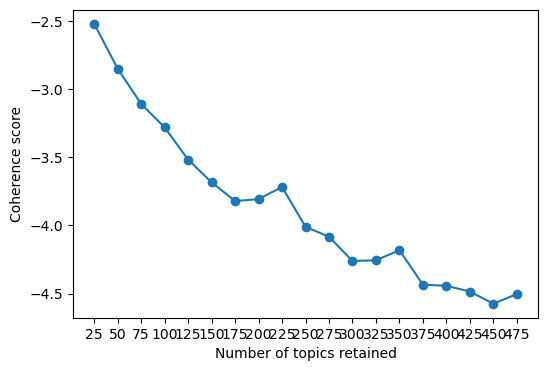

In [19]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(25, 500, 25))
plt.show()

In [20]:
mdl = tp.LDAModel(k=450, corpus=corpus, rm_top=3, min_df=10)
mdl.train(10)

In [21]:
mdl.summary()

<Basic Info>
| LDAModel (current version: 0.12.4)
| 30512 docs, 374339 words
| Total Vocabs: 15997, Used Vocabs: 3446
| Entropy of words: 7.12680
| Entropy of term-weighted words: 7.12680
| Removed Vocabs: car abarth like
|
<Training Info>
| Iterations: 10, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -9.92527
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 450 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 645325340 (random seed)
| trained in version 0.12.4
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)


# Sentiment Analysis (old)

In [120]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Alvis
[nltk_data]     Cheung\AppData\Roaming\nltk_data...


True

In [135]:
df1=pd.DataFrame()
df1['row_id']=['99999999999']
df1['sentiment_type']='NA999NA'
df1['sentiment_score']=0
df1

,row_id,sentiment_type,sentiment_score
0,99999999999,NA999NA,0


In [233]:
print('Processing sentiment analysis...')
sid = SentimentIntensityAnalyzer()
t_df = df1
for index, row in enumerate(dfCleanCleanText1):
    scores = sid.polarity_scores(row)
    for key, value in scores.items():
        temp = [key,value,index]
        df1['row_id']=index
        df1['sentiment_type']=key
        df1['sentiment_score']=value
        #print(df1)
        t_df = pd.concat([t_df,df1])
#remove dummy row with row_id = 99999999999
t_df_cleaned = t_df[t_df.row_id != '99999999999']
#remove duplicates if any exist
t_df_cleaned = t_df_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
t_df_cleaned = t_df[t_df.sentiment_type == 'compound']
print(t_df_cleaned.head(10))

Processing sentiment analysis...
   row_id sentiment_type  sentiment_score
0       0       compound           0.8402
0       1       compound           0.8720
0       2       compound           0.9367
0       3       compound           0.7964
0       4       compound           0.1027
0       5       compound           0.0000
0       6       compound           0.3829
0       7       compound           0.2960
0       8       compound           0.4588
0       9       compound           0.1280


In [234]:
t_df_cleaned

,row_id,sentiment_type,sentiment_score
0,0,compound,0.8402
0,1,compound,0.8720
0,2,compound,0.9367
0,3,compound,0.7964
0,4,compound,0.1027
...,...,...,...
0,1836,compound,0.5994
0,1837,compound,0.2960
0,1838,compound,-0.0387
0,1839,compound,-0.1419


In [235]:
dfCleanCleanText1[0]

'Hello everyone I own a 2016 Abarth 595 which has now developed a squealing noise so I think this is due to the brakes in need of replacement but I’m looking to upgrade from the stock brakes has anyone got any suggestions on upgrades that DON’T cost £1000 😂 any help would be appreciated'

In [157]:
sid.polarity_scores("I am very happy")

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [151]:
sid.polarity_scores("My friend said I shot a solid 2 foot flame out of my car last night. Stock exhaust. Just curious if any of y'all have done it")

{'neg': 0.075, 'neu': 0.683, 'pos': 0.242, 'compound': 0.5994}